#### Introduction / Business Problem

The aim of this project, the largest metropolitan area in Istanbul, is to find a suitable place to open a cafe in Turkey. I chose Taksim Square, the busiest and most crowded square in Istanbul, to open the cafe. However, Taksim Square is closed to car traffic. For this reason, customers have to use the subway to the cafe. The first requirement is that the new cafe is easily accessible to potential customers and more specifically is located near a metro station. If possible, the number of cafes currently available in an area should also be taken into account to avoid fierce competition. It can serve as the first starting point for locations to consider starting business. In order to achieve the project goals, python geolocation libraries will be used together with the Foursquare API. Also, the K-Means machine learning clustering algorithm will be used to create clusters from similar candidate locations.

#### Data

Data Based on the above mentioned requirements, the required data for this project are: Metro stations around Istanbul and Taksim Square Number of available cafes near each station In addition, the distance to the nearest cafe will be used for each metro station. To obtain the data, a combination of the geopy Python library and Foursquare API will be used: 1. "Taksim square" will be accepted as the center. I will get the geospatial coordinates using the Geopy library 2. Foursquare API, which has the coordinates of Taksim Square, will be used to obtain data for all metro stations within a 3 km radius. 3. To find existing cafes near subway stations, the Foursquare API will be used again for each station. I will get data for all cafes within a radius of 500 meters of each metro station Using the data collected, I will calculate the number of available cafes near each station. I will also be able to determine the minimum distance to a cafe for each metro station. This minimum distance from a cafe to each subway station, along with the number of cafes currently available near the station, will be used as input to the K-Means clustering algorithm to obtain clusters of areas (metro stations).

#### Import libraries

In [1]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import pandas as pd
# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from pandas.io.json import json_normalize

import folium # map rendering library

import requests

import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.pyplot import subplots

from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


#### Data Acquisition, Cleaning and Transformation

In [2]:
address = 'Taksim Square, Turkey'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)

In [3]:
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Taksim Square are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Taksim Square are 41.0369635, 28.9851445.


In [4]:
string = str(latitude) + ', ' +str(longitude)
address = geolocator.reverse(string, language='en')
address

Location(Taksim Square, Istanbul Taksim Square, Taksim, Gümüşsuyu, Gümüşsuyu Mahallesi, Beyoğlu, Istanbul, Marmara Region, 34437, Turkey, (41.0369635, 28.9851445, 0.0))

In [5]:
map_taksim = folium.Map(location=[latitude, longitude], zoom_start=18)
folium.Marker([latitude, longitude], popup='Taksim Square').add_to(map_taksim)
map_taksim

In [6]:
CLIENT_ID = 'R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K' # your Foursquare ID
CLIENT_SECRET = '4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW' # your Foursquare Secret

radius = 3000
VERSION = '20180604' # Foursquare API version
LIMIT = 100
category_id = '4bf58dd8d48988d1fd931735' # Metro Stations

In [7]:
url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude, 
    radius,
    LIMIT
)

In [8]:
stations_list = requests.get(url).json()['response']['groups'][0]['items']
stations_init_df = json_normalize(stations_list)

stations_init_df.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.postalCode,venue.location.neighborhood,venue.location.crossStreet
0,e-0-50c4b625e4b09f38ad8ec3e6-0,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",50c4b625e4b09f38ad8ec3e6,Yenikapı - Hacıosman Metrosu (M2),Yenikapı - Hacıosman,41.037024,28.986311,"[{'label': 'display', 'lat': 41.03702425691598, 'lng': 28.9863109588623}]",98,TR,İstanbul,İstanbul,Türkiye,"[Yenikapı - Hacıosman, İstanbul, Türkiye]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN,NaN
1,e-0-5288d410498e7772649ad89f-1,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",5288d410498e7772649ad89f,Füniküler,Taksim - Kabataş,41.036917,28.985767,"[{'label': 'display', 'lat': 41.03691652353387, 'lng': 28.985767210754613}]",52,TR,İstanbul,İstanbul,Türkiye,"[Taksim - Kabataş, İstanbul, Türkiye]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN,NaN
2,e-0-4db6dd6b6a23c31a03475eac-2,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4db6dd6b6a23c31a03475eac,Taksim Füniküler İstasyonu,Taksim,41.036734,28.986200,"[{'label': 'display', 'lat': 41.03673351790656, 'lng': 28.986199682588463}]",92,TR,Beyoğlu,İstanbul,Türkiye,"[Taksim, Beyoğlu, Türkiye]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN,NaN
3,e-0-4bd236cea8b3a5939473675f-3,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4bd236cea8b3a5939473675f,Taksim Metro İstasyonu,Taksim,41.037025,28.985483,"[{'label': 'display', 'lat': 41.03702492026115, 'lng': 28.98548342359113}]",29,TR,Beyoğlu,İstanbul,Türkiye,"[Taksim, Beyoğlu, Türkiye]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN,NaN
4,e-0-4b9fc3f7f964a5208b3c37e3-4,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4b9fc3f7f964a5208b3c37e3,Kabataş Füniküler İstasyonu,Kabataş,41.034011,28.992413,"[{'label': 'display', 'lat': 41.03401119089131, 'lng': 28.992413205813}]",693,TR,Beyoğlu,İstanbul,Türkiye,"[Kabataş, Beyoğlu, Türkiye]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN,NaN


In [9]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance', 'venue.location.postalCode']
stations_filtered_df = stations_init_df.loc[:, filtered_columns]

# filter the category for each row
stations_filtered_df['venue_type'] = stations_init_df['venue.categories'].apply(lambda x: dict(x[0])['name'])

# clean columns
stations_filtered_df.columns = [col.split('.')[-1] for col in stations_filtered_df.columns]
stations_df = stations_filtered_df[stations_filtered_df['venue_type'] == 'Metro Station']
stations_df = stations_df.drop('categories', axis=1)
stations_df.head()


,name,lat,lng,distance,postalCode,venue_type
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,98,NaN,Metro Station
1,Füniküler,41.036917,28.985767,52,NaN,Metro Station
2,Taksim Füniküler İstasyonu,41.036734,28.986200,92,NaN,Metro Station
3,Taksim Metro İstasyonu,41.037025,28.985483,29,NaN,Metro Station
4,Kabataş Füniküler İstasyonu,41.034011,28.992413,693,NaN,Metro Station


In [10]:
stations_df.rename(columns={'name': 'station',
                            'distance': 'Distance from Center',
                            'postalCode': 'Postal Code',
                            'venue_type': 'Venue Type'},
                   inplace=True)

stations_df.reset_index(drop=True, inplace=True)

print(stations_df.info())
stations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
station                 27 non-null object
lat                     27 non-null float64
lng                     27 non-null float64
Distance from Center    27 non-null int64
Postal Code             3 non-null object
Venue Type              27 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 1.4+ KB
None


,station,lat,lng,Distance from Center,Postal Code,Venue Type
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,98,NaN,Metro Station
1,Füniküler,41.036917,28.985767,52,NaN,Metro Station
2,Taksim Füniküler İstasyonu,41.036734,28.986200,92,NaN,Metro Station
3,Taksim Metro İstasyonu,41.037025,28.985483,29,NaN,Metro Station
4,Kabataş Füniküler İstasyonu,41.034011,28.992413,693,NaN,Metro Station


In [13]:
map_taksim = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, station in zip(stations_df['lat'],
                          stations_df['lng'],
                          stations_df['station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_taksim)
    
map_taksim

In [14]:
def getNearbyCafes(categoryId, stations, latitudes, longitudes, radius=750):
    
    cafes_list=[]
    for station, lat, lng in zip(stations, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        cafes_list.append([(
            station,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']
        ) for v in results])

    nearby_cafes_df = pd.DataFrame([item for venue_list in cafes_list for item in venue_list])
    nearby_cafes_df.columns = [
                  'station',
                  'lat',
                  'lng',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Distance from Station',
                  'Venue Category']
    return(nearby_cafes_df)

In [15]:
categoryId = '4bf58dd8d48988d16d941735' # Cafes
cafes_venues_df = getNearbyCafes(categoryId, stations=stations_df['station'], latitudes=stations_df['lat'], longitudes=stations_df['lng'])
cafes_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Bistrot Français,41.036261,28.983871,221,Café
1,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Gezi İstanbul,41.036382,28.987350,112,Café
2,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Taksim My House,41.034924,28.985417,245,Café
3,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Escape Cafe,41.035984,28.982382,349,Café
4,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Cafee QIRIX MUTFAK,41.034904,28.983121,356,Café


In [16]:
cafes_venues_df.groupby(['Venue Category']).count()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Bar,1,1,1,1,1,1,1
Bistro,2,2,2,2,2,2,2
Bookstore,11,11,11,11,11,11,11
Breakfast Spot,4,4,4,4,4,4,4
Café,2193,2193,2193,2193,2193,2193,2193
Chocolate Shop,2,2,2,2,2,2,2
Coffee Shop,80,80,80,80,80,80,80
Dessert Shop,3,3,3,3,3,3,3
Diner,1,1,1,1,1,1,1


In [17]:
cafes_venues_dff = cafes_venues_df[cafes_venues_df['Venue Category'].isin(['Café','Coffee Shop','Dessert Shop','Chocolate Shop'])]
cafes_venues_dff.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Bistrot Français,41.036261,28.983871,221,Café
1,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Gezi İstanbul,41.036382,28.987350,112,Café
2,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Taksim My House,41.034924,28.985417,245,Café
3,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Escape Cafe,41.035984,28.982382,349,Café
4,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Cafee QIRIX MUTFAK,41.034904,28.983121,356,Café


In [18]:
cafes_venues_dff.groupby(['Venue Category']).count().head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Café,2193,2193,2193,2193,2193,2193,2193
Chocolate Shop,2,2,2,2,2,2,2
Coffee Shop,80,80,80,80,80,80,80
Dessert Shop,3,3,3,3,3,3,3


In [19]:
cafes_venues_min_df = pd.merge(cafes_venues_dff,
                              pd.DataFrame(cafes_venues_dff.groupby('station')['Distance from Station'].min()),
                              on='station', how='inner')
cafes_venues_min_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Bistrot Français,41.036261,28.983871,221,Café,104
1,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Gezi İstanbul,41.036382,28.987350,112,Café,104
2,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Taksim My House,41.034924,28.985417,245,Café,104
3,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Escape Cafe,41.035984,28.982382,349,Café,104
4,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Cafee QIRIX MUTFAK,41.034904,28.983121,356,Café,104


In [20]:
cafes_venues_min_count_df = pd.merge(cafes_venues_min_df,
                           pd.DataFrame(cafes_venues_min_df.groupby(['station']).count())['lat'],
                           on='station', how='inner')

cafes_venues_min_count_df.head()

,station,lat_x,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y,lat_y
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Bistrot Français,41.036261,28.983871,221,Café,104,99
1,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Gezi İstanbul,41.036382,28.987350,112,Café,104,99
2,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Taksim My House,41.034924,28.985417,245,Café,104,99
3,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Escape Cafe,41.035984,28.982382,349,Café,104,99
4,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,Cafee QIRIX MUTFAK,41.034904,28.983121,356,Café,104,99


In [21]:
cafes_df = cafes_venues_min_count_df.rename(columns={'lat_x': 'lat', 'Distance from Station_x': 'Distance from Station',
                                                   'Distance from Station_y': 'Min Distance from Station',
                                                   'lat_y': 'Cafes Count'})
cafes_df = cafes_df[['station', 'lat', 'lng', 'Min Distance from Station', 'Cafes Count']].drop_duplicates()
cafes_df.head()

,station,lat,lng,Min Distance from Station,Cafes Count
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,104,99
99,Füniküler,41.036917,28.985767,96,96
195,Taksim Füniküler İstasyonu,41.036734,28.986200,104,96
291,Taksim Metro İstasyonu,41.037025,28.985483,82,97
388,Kabataş Füniküler İstasyonu,41.034011,28.992413,38,90


In [22]:
missing_stations_df = pd.merge(stations_df[['station', 'lat', 'lng']], cafes_df,
                                    on='station', how='left')
missing_stations_df[missing_stations_df['Cafes Count'].isnull()]

,station,lat_x,lng_x,lat_y,lng_y,Min Distance from Station,Cafes Count


In [23]:
stations_cafes_grouped_df = cafes_df.copy()

In [24]:
stations_cafes_grouped_df.head()

,station,lat,lng,Min Distance from Station,Cafes Count
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,104,99
99,Füniküler,41.036917,28.985767,96,96
195,Taksim Füniküler İstasyonu,41.036734,28.986200,104,96
291,Taksim Metro İstasyonu,41.037025,28.985483,82,97
388,Kabataş Füniküler İstasyonu,41.034011,28.992413,38,90


In [25]:
print('All stations mean distance from any cafe: ', stations_cafes_grouped_df['Min Distance from Station'].mean())
print('All stations maximum distance from any cafe: ',stations_cafes_grouped_df['Min Distance from Station'].max())
print('All stations minimum distance from any cafe: ', stations_cafes_grouped_df['Min Distance from Station'].min())
print('All stations mean of number of existing cafes: ', stations_cafes_grouped_df['Cafes Count'].mean())
print('All stations maximum number of existing cafes: ', stations_cafes_grouped_df['Cafes Count'].max())
print('All stations minimum number of existing cafes: ', stations_cafes_grouped_df['Cafes Count'].min())

All stations mean distance from any cafe:  101.03703703703704
All stations maximum distance from any cafe:  596
All stations minimum distance from any cafe:  6
All stations mean of number of existing cafes:  84.37037037037037
All stations maximum number of existing cafes:  99
All stations minimum number of existing cafes:  5


In [26]:
stations_cafes_grouped_df['Norm Min Distance from Station'] = (stations_cafes_grouped_df['Min Distance from Station'] - \
                                                              stations_cafes_grouped_df['Min Distance from Station'].mean()) / \
                                                             (stations_cafes_grouped_df['Min Distance from Station'].max() - \
                                                              stations_cafes_grouped_df['Min Distance from Station'].min())
stations_cafes_grouped_df['Norm Cafe Count'] = (stations_cafes_grouped_df['Cafes Count'] - stations_cafes_grouped_df['Cafes Count'].mean()) / \
                                             (stations_cafes_grouped_df['Cafes Count'].max() - stations_cafes_grouped_df['Cafes Count'].min())

In [27]:
stations_cafes_grouped_df['Cafes Count'] = stations_cafes_grouped_df['Cafes Count'].astype(int)
stations_cafes_grouped_df.reset_index(drop=True, inplace=True)
stations_cafes_grouped_df.head(10)

,station,lat,lng,Min Distance from Station,Cafes Count,Norm Min Distance from Station,Norm Cafe Count
0,Yenikapı - Hacıosman Metrosu (M2),41.037024,28.986311,104,99,0.005022,0.155634
1,Füniküler,41.036917,28.985767,96,96,-0.008537,0.123719
2,Taksim Füniküler İstasyonu,41.036734,28.986200,104,96,0.005022,0.123719
3,Taksim Metro İstasyonu,41.037025,28.985483,82,97,-0.032266,0.134358
4,Kabataş Füniküler İstasyonu,41.034011,28.992413,38,90,-0.106842,0.059890
5,KMM Metrosu | Kabataş Makas Şaftı Şantiyesi,41.036028,28.994400,63,65,-0.064470,-0.206068
6,Şişhane Metro İstasyonu,41.028781,28.974901,25,95,-0.128876,0.113081
7,Başakşehir Metrosu,41.034320,28.972272,248,93,0.249090,0.091805
8,Tunnel,41.024618,28.978423,6,98,-0.161080,0.144996
9,Pangaltı Metrosu,41.051382,28.987316,10,94,-0.154300,0.102443


In [28]:
cafes_clustering_df = stations_cafes_grouped_df.drop(['station', 'lat', 'lng', 'Min Distance from Station', 'Cafes Count'], 1)
cafes_clustering_df.head()

,Norm Min Distance from Station,Norm Cafe Count
0,0.005022,0.155634
1,-0.008537,0.123719
2,0.005022,0.123719
3,-0.032266,0.134358
4,-0.106842,0.059890


#### K-Means Clustering

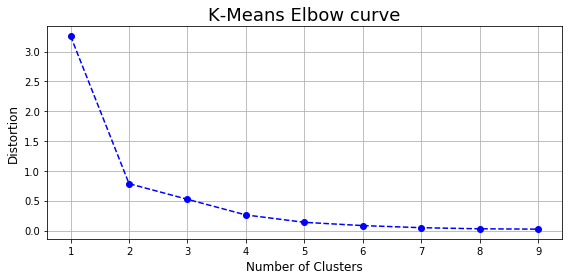

In [29]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(1, 10):
    kmeans = KMeans(init="k-means++", n_clusters=k, random_state=0, n_init = 12, max_iter=300, tol=0.00001)
    kmeans.fit(cafes_clustering_df)
    distorsions.append(kmeans.inertia_)

fig, ax = subplots(figsize=(8, 4))
ax.plot(range(1, 10), distorsions, '--bo')
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Distortion', fontsize=12)
plt.grid(True)
plt.title('K-Means Elbow curve', fontsize='18')
plt.tight_layout()
plt.show()

In [30]:
kmeans = KMeans(init="k-means++", n_clusters=3, random_state=0, n_init = 12, max_iter=300, tol=0.0001)
kmeans.fit(cafes_clustering_df)

kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 1])

In [31]:
stations_cafes_grouped_df.insert(1, 'Cluster Label', kmeans.labels_)

In [32]:
stations_cafes_grouped_df.head(30)

,station,Cluster Label,lat,lng,Min Distance from Station,Cafes Count,Norm Min Distance from Station,Norm Cafe Count
0,Yenikapı - Hacıosman Metrosu (M2),1,41.037024,28.986311,104,99,0.005022,0.155634
1,Füniküler,1,41.036917,28.985767,96,96,-0.008537,0.123719
2,Taksim Füniküler İstasyonu,1,41.036734,28.986200,104,96,0.005022,0.123719
3,Taksim Metro İstasyonu,1,41.037025,28.985483,82,97,-0.032266,0.134358
4,Kabataş Füniküler İstasyonu,1,41.034011,28.992413,38,90,-0.106842,0.059890
5,KMM Metrosu | Kabataş Makas Şaftı Şantiyesi,1,41.036028,28.994400,63,65,-0.064470,-0.206068
6,Şişhane Metro İstasyonu,1,41.028781,28.974901,25,95,-0.128876,0.113081
7,Başakşehir Metrosu,1,41.034320,28.972272,248,93,0.249090,0.091805
8,Tunnel,1,41.024618,28.978423,6,98,-0.161080,0.144996
9,Pangaltı Metrosu,1,41.051382,28.987316,10,94,-0.154300,0.102443


In [33]:
cluster_colors = ['gray', 'purple', 'darkblue']

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

markers_colors = []
for lat, lon, poi, cluster in zip(stations_cafes_grouped_df['lat'], stations_cafes_grouped_df['lng'], 
                                  stations_cafes_grouped_df['station'], stations_cafes_grouped_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_colors[cluster],
        fill=True,
        fill_color=cluster_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

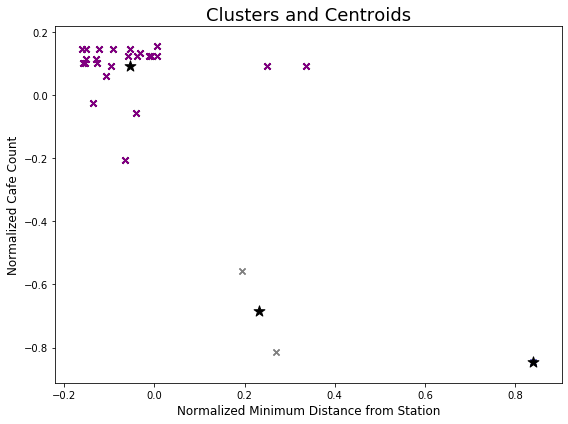

In [34]:
fig, ax = subplots(figsize=(8, 6))
for label in kmeans.labels_:
    plt.scatter(stations_cafes_grouped_df[stations_cafes_grouped_df['Cluster Label'] == label]['Norm Min Distance from Station'],
                stations_cafes_grouped_df[stations_cafes_grouped_df['Cluster Label'] == label]['Norm Cafe Count'],
                marker='x', color=cluster_colors[label])
for centroid in kmeans.cluster_centers_:
#     print(centroid)
    plt.scatter(centroid[0], centroid[1], s=130, marker="*", color='black')
ax.set_xlabel('Normalized Minimum Distance from Station', fontsize=12)
ax.set_ylabel('Normalized Cafe Count', fontsize=12)
plt.title('Clusters and Centroids', fontsize='18')
plt.tight_layout()
plt.show()


In [35]:
stations_cafes_grouped_df.loc[stations_cafes_grouped_df['Cluster Label'] == 0]

,station,Cluster Label,lat,lng,Min Distance from Station,Cafes Count,Norm Min Distance from Station,Norm Cafe Count
12,Boğaz'ın En Derin Yeri,0,41.019967,28.990923,260,8,0.269429,-0.812451
24,zincirlikuyu,0,41.048247,29.015671,216,32,0.194852,-0.557132


In [36]:
stations_cafes_grouped_df.loc[stations_cafes_grouped_df['Cluster Label'] == 1]

,station,Cluster Label,lat,lng,Min Distance from Station,Cafes Count,Norm Min Distance from Station,Norm Cafe Count
0,Yenikapı - Hacıosman Metrosu (M2),1,41.037024,28.986311,104,99,0.005022,0.155634
1,Füniküler,1,41.036917,28.985767,96,96,-0.008537,0.123719
2,Taksim Füniküler İstasyonu,1,41.036734,28.986200,104,96,0.005022,0.123719
3,Taksim Metro İstasyonu,1,41.037025,28.985483,82,97,-0.032266,0.134358
4,Kabataş Füniküler İstasyonu,1,41.034011,28.992413,38,90,-0.106842,0.059890
5,KMM Metrosu | Kabataş Makas Şaftı Şantiyesi,1,41.036028,28.994400,63,65,-0.064470,-0.206068
6,Şişhane Metro İstasyonu,1,41.028781,28.974901,25,95,-0.128876,0.113081
7,Başakşehir Metrosu,1,41.034320,28.972272,248,93,0.249090,0.091805
8,Tunnel,1,41.024618,28.978423,6,98,-0.161080,0.144996
9,Pangaltı Metrosu,1,41.051382,28.987316,10,94,-0.154300,0.102443


In [37]:
stations_cafes_grouped_df.loc[stations_cafes_grouped_df['Cluster Label'] == 2]

,station,Cluster Label,lat,lng,Min Distance from Station,Cafes Count,Norm Min Distance from Station,Norm Cafe Count
25,Marmaray,2,41.012321,28.994722,596,5,0.83892,-0.844366


#### Discussion

Metro stations have been identified as similar groups in their potential location to open a cafe.

Possible areas that are not included in the Foursquare database should also be examined, so that it can be determined whether there is a lack of data on these stations or whether there are cafes near the stations. Many more factors can be taken into account when choosing a suitable location. Some examples of extra factors could be:

The number of businesses operating in the region (the more workplaces, the more employees come to the cafe after work.)
Average age in the area
Average income in the region
Property prices in the region
Population density in the region
Other public transport in the area

#### Conclusion

The results we have obtained contain important information for someone who wants to open a cafe. Likewise, other types of businesses can get a good starting point using the same route.